# Loading

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import helper as hp

import os
from abc import ABC, abstractmethod
from collections import defaultdict
import warnings

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import mplfinance as mpf
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
from statsmodels.tsa.stattools import adfuller, kpss
from models import * 

current_path = os.getcwd()
random_state = hp.RANDOM_STATE

current_path = os.getcwd()
random_state = hp.RANDOM_STATE
STOCKS = ["TSLA", "AAPL", 'QQQ', "SPY", "MSFT", "AMZN", "GOOG", "DIA", "^IRX"]
START_DATE = hp.START_DATE
END_DATE = hp.END_DATE
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [4]:
# data fetching 
stock_data = {}
for stock in STOCKS:
    data_path = os.path.join(current_path, "data", f"{stock}_{START_DATE}_{END_DATE}.csv")
    data = pd.read_csv(data_path)
    stock_data[stock] = data
stock_data = hp.preprocess_stock_data(stock_data, STOCKS)

Data fetched for TSLA
Data fetched for AAPL
Data fetched for QQQ
Data fetched for SPY
Data fetched for MSFT
Data fetched for AMZN
Data fetched for GOOG
Data fetched for DIA
Data fetched for ^IRX


# Non-Stationary

In [40]:
fromDate = "2015-01-01"
toDate = '2023-01-01'
# fromDate = "2015-01-01"
# toDate = '2017-01-01'
stock = 'AAPL'
lag = 5
X, y, df_stock = hp.prepare_data(stock_data, stock, fromDate, toDate, lag, stationary=False)
window_size = 10
starting_funds = 50000


## XGBoost

In [21]:
loss_fn = 'reg:squarederror' #'reg:pseudohubererror'
xgboost_model = XGBoost(loss_fn)
xgboost_stock_predictor = StockPredictor(xgboost_model, window_size=window_size, stationary=False)
xgboost_stock_predictor.fit_predict(X, y)
xgboost_stock_predictor.print_metrics()

Processing: 100%|██████████| 1986/1986 [01:02<00:00, 31.93it/s]

Mean Squared Error (MSE): 7.5039
Mean Absolute Error (MAE): 1.5520


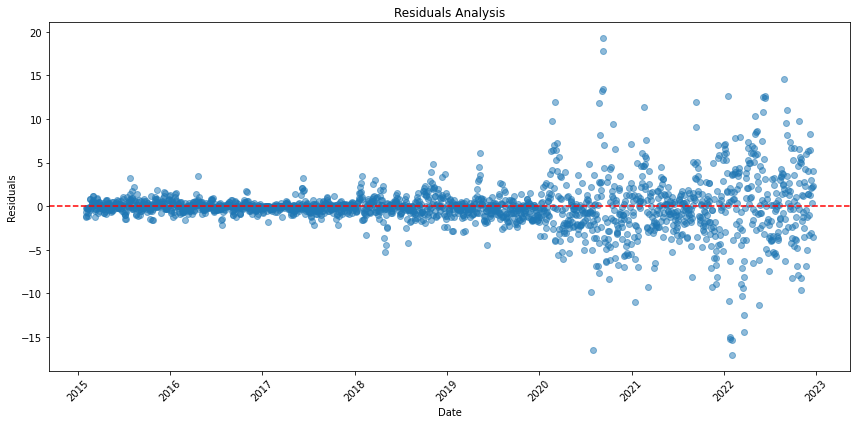

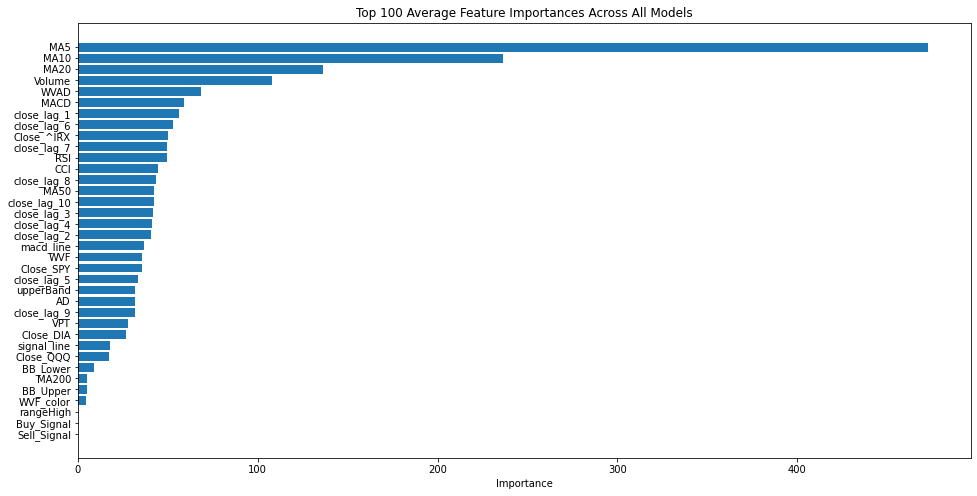

In [28]:
xgboost_stock_predictor.plot_residuals()
xgboost_stock_predictor.show_feature_importance(n=100)

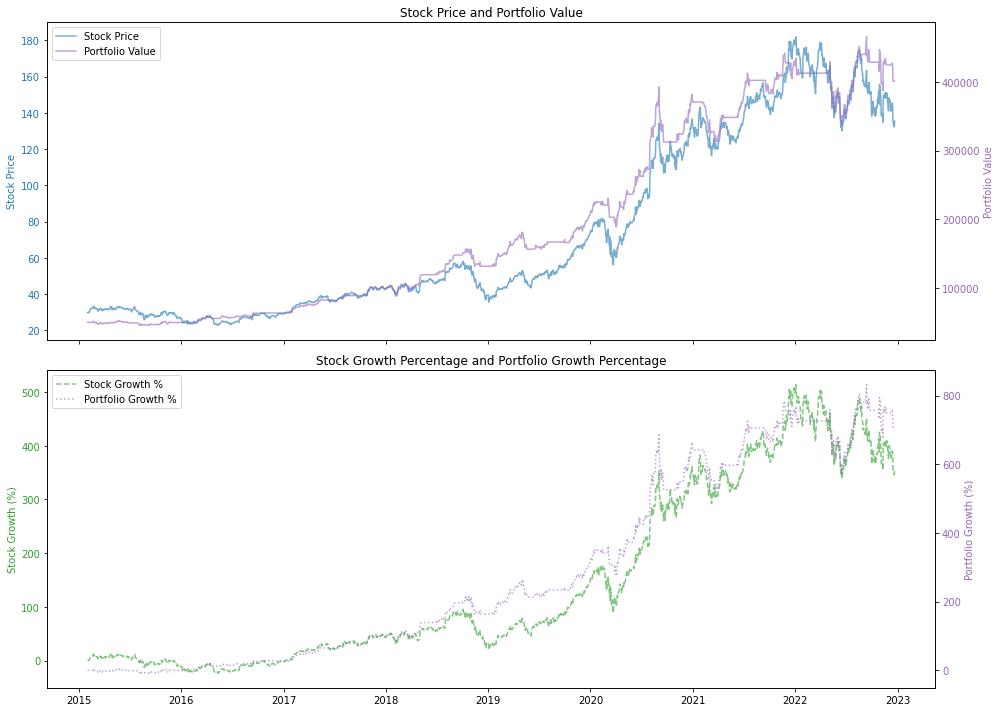

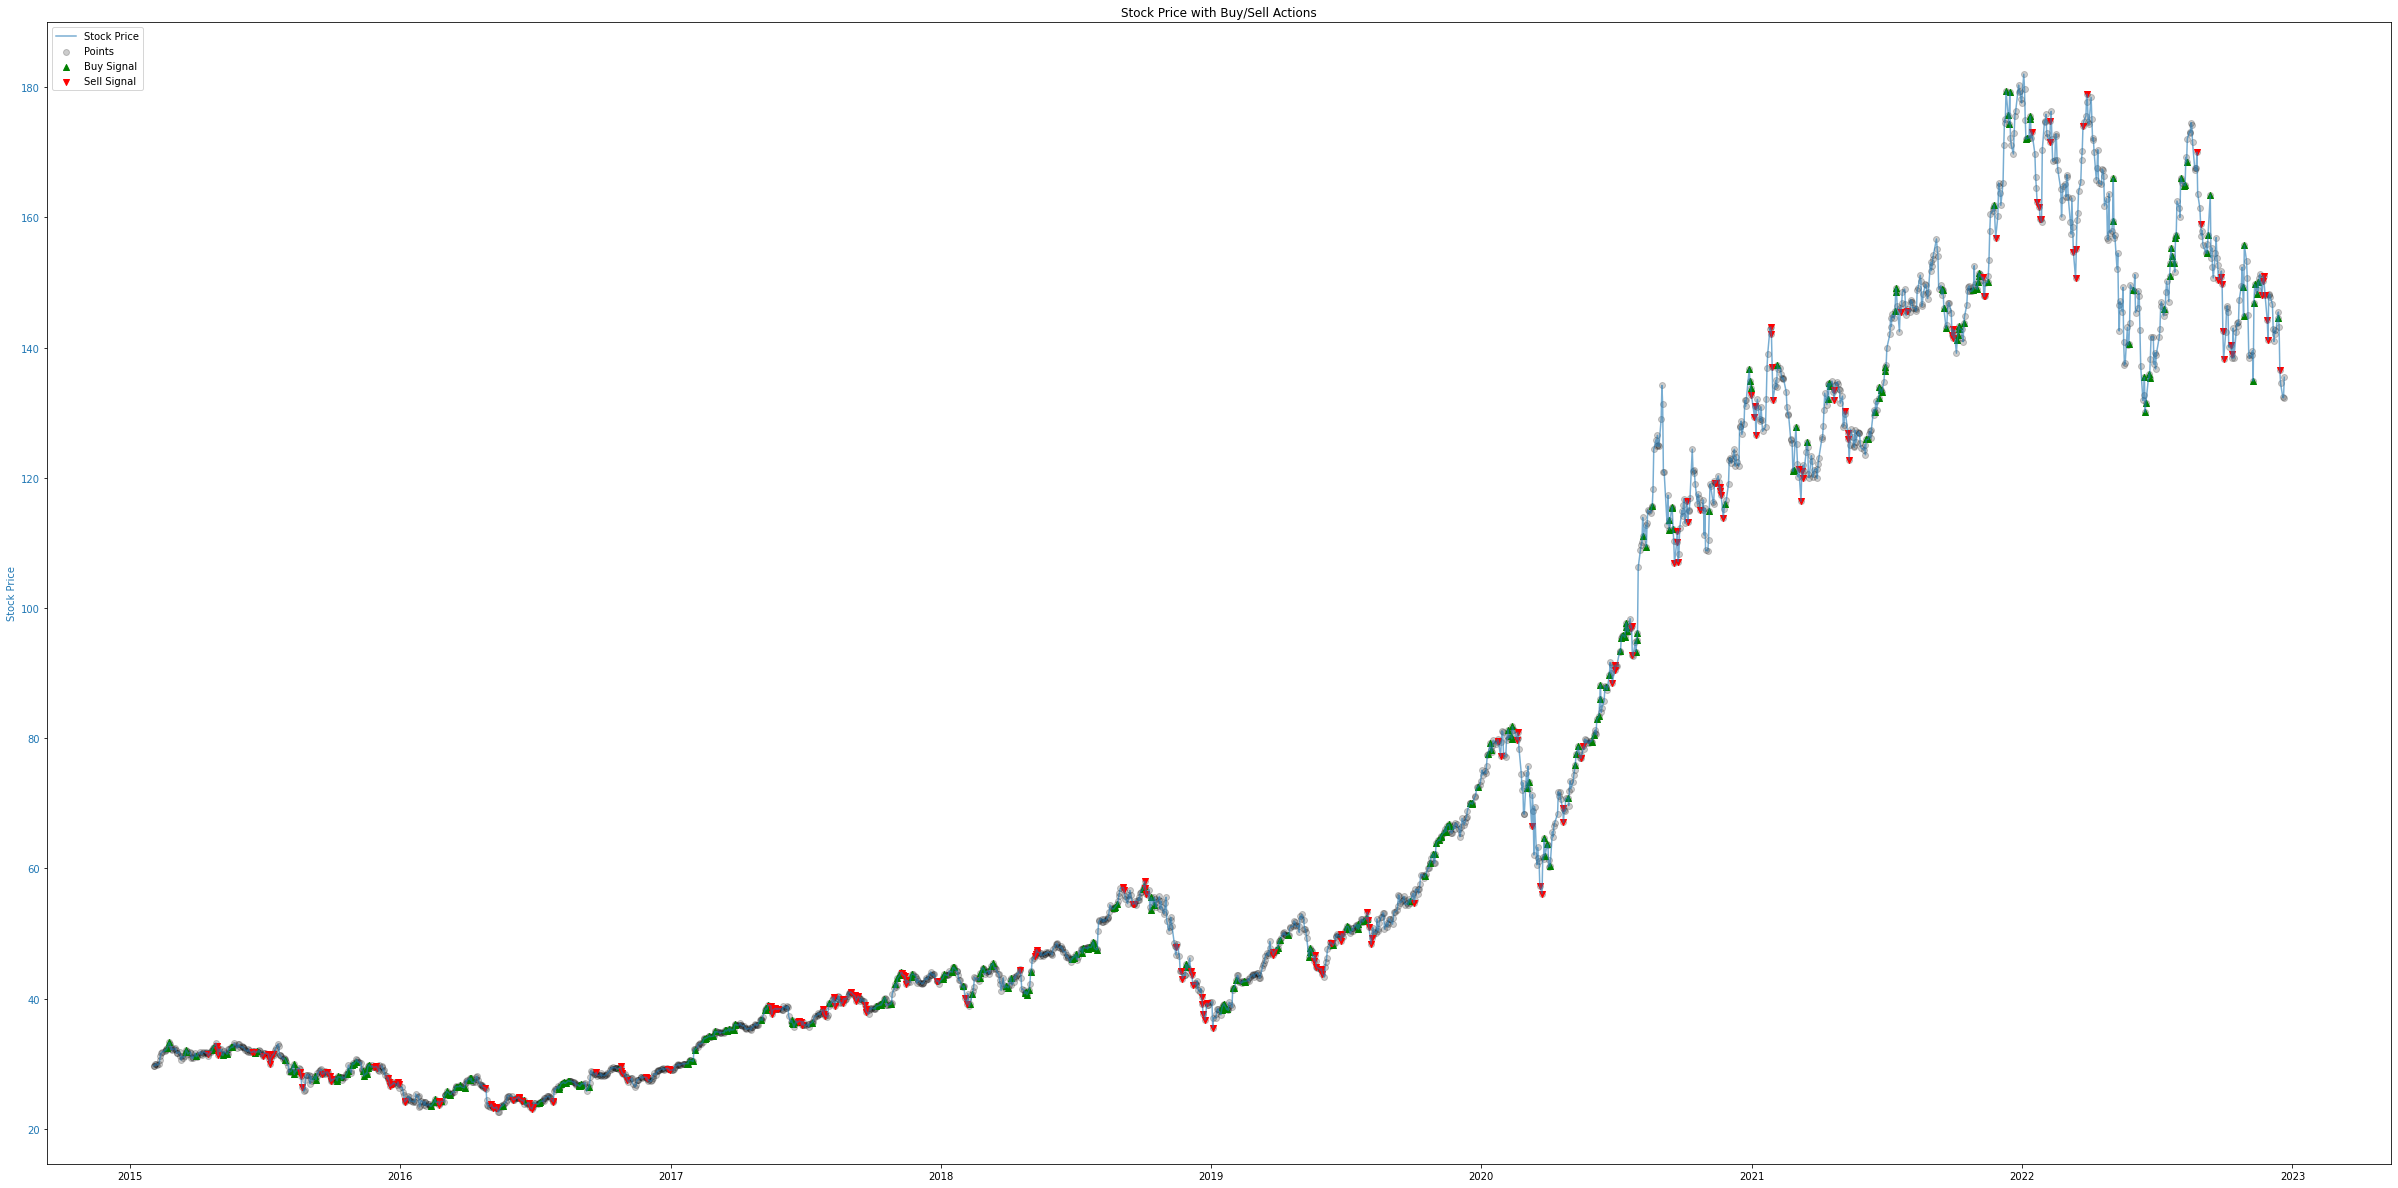

In [53]:
hp.trading_strategy(df_stock=df_stock, window_size=window_size, 
    true_returns=xgboost_stock_predictor.true_returns,
    predicted_returns=xgboost_stock_predictor.predicted_returns,
    starting_funds=50000
)

## Random Forest

In [32]:
loss_fn = "squared_error" #'absolute_error', 'poisson', 'friedman_mse', 'squared_error'
rf_model = RandomForest(loss_fn)
rf_stock_predictor = StockPredictor(rf_model, window_size=window_size, stationary=False)
rf_stock_predictor.fit_predict(X, y)
rf_stock_predictor.print_metrics()

Processing: 100%|██████████| 1986/1986 [05:10<00:00,  6.39it/s]

Mean Squared Error (MSE): 5.0464
Mean Absolute Error (MAE): 1.3811


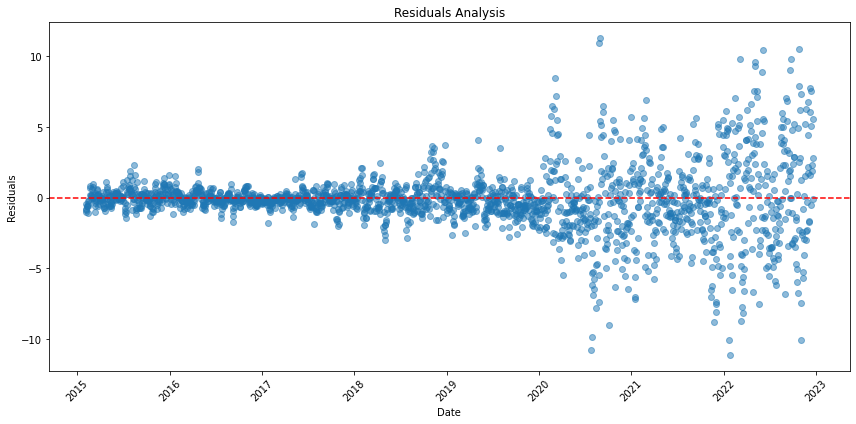

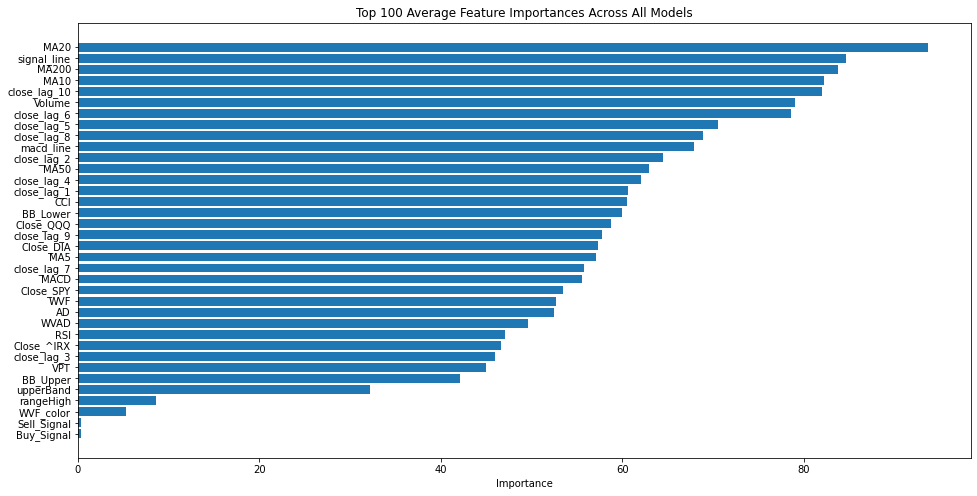

In [35]:
rf_stock_predictor.plot_residuals()
rf_stock_predictor.show_feature_importance(n=100)

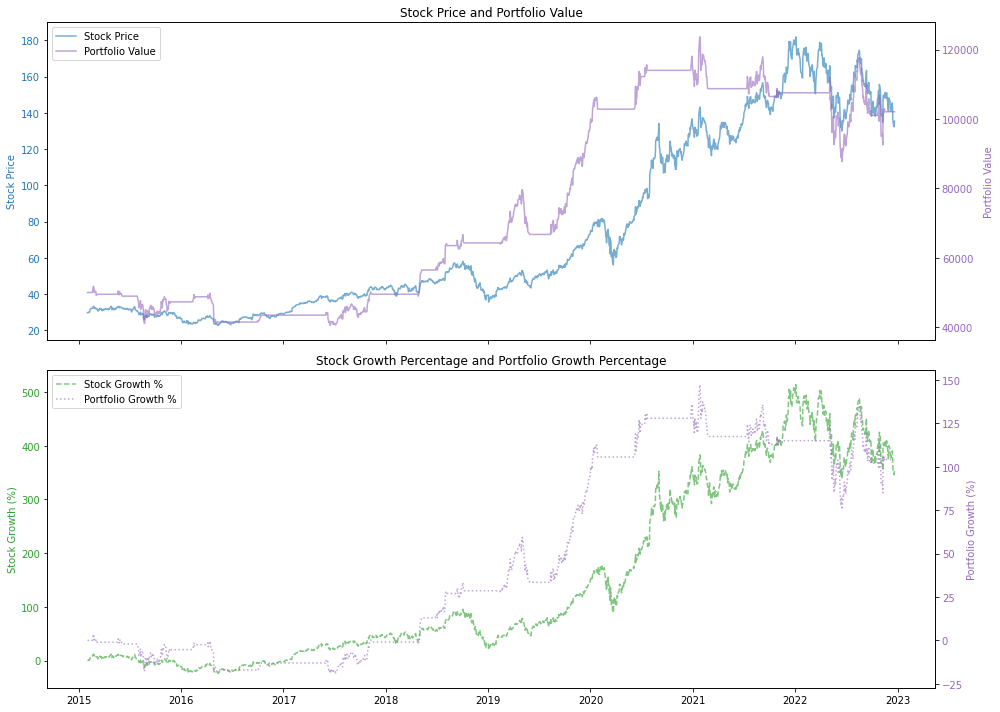

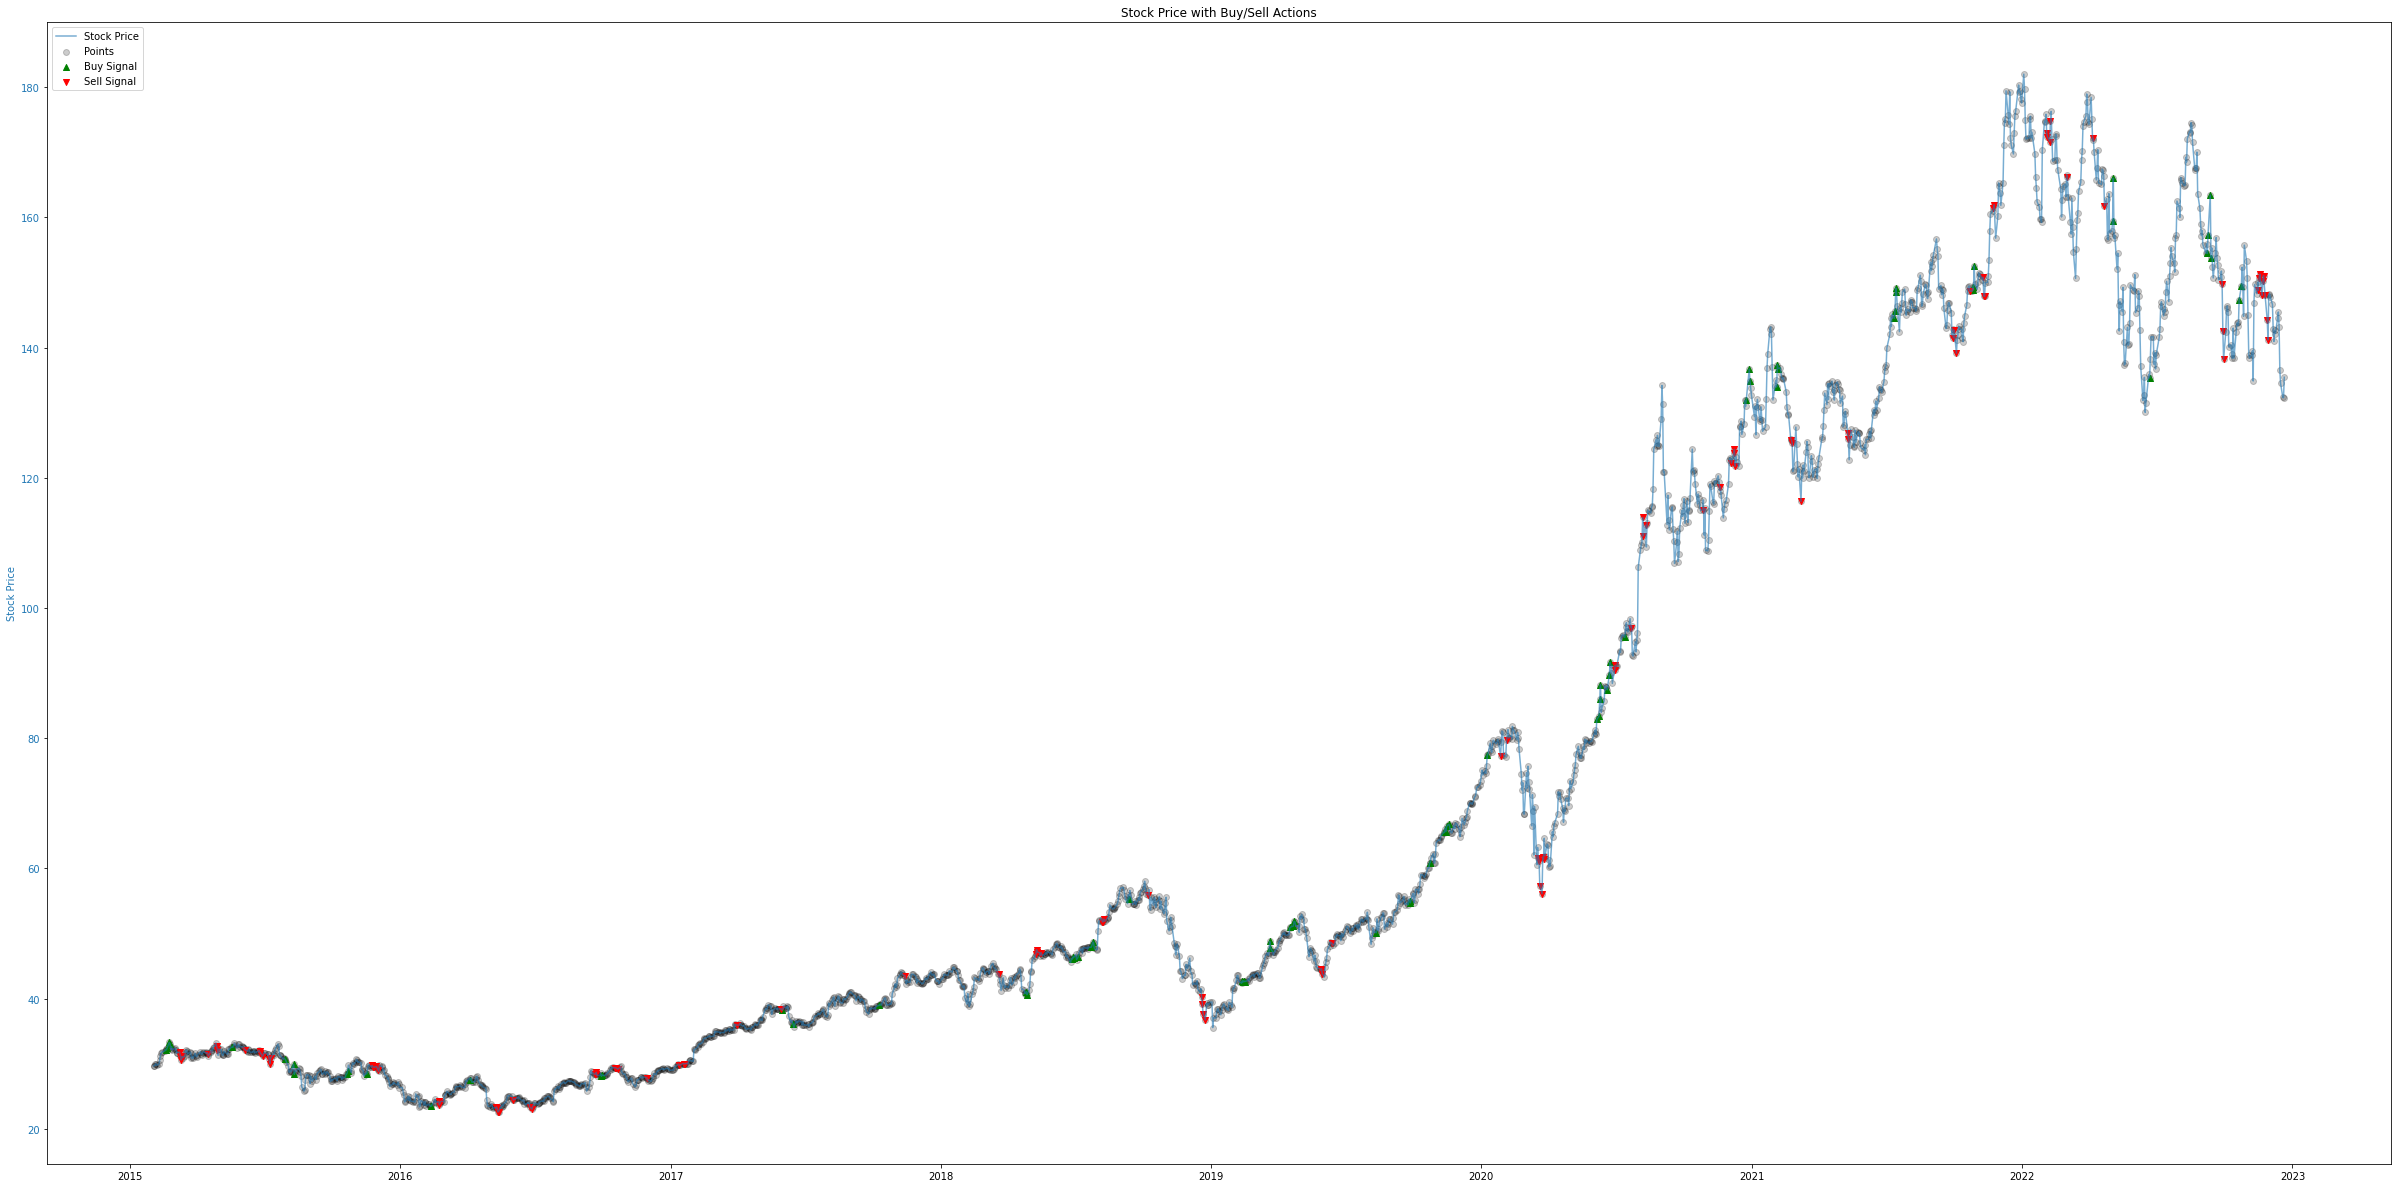

In [52]:
hp.trading_strategy(df_stock=df_stock, window_size=window_size, 
    true_returns=rf_stock_predictor.true_returns,
    predicted_returns=rf_stock_predictor.predicted_returns,
    starting_funds=50000
)

## LSTM

# Stationary

## Preprocessing & Stationarity Check

## XGBoost

## Random Forest

## LSTM